In [18]:
import os
import sys
sys.path.append("..")

import torch
from utils.specs import CheckpointSpecs, load_checkpoint_config, load_checkpoint_model
import src.experiments_maker as experiments_maker
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.config_manager as cm
import utils.density_plot as dp
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
# set high dpi
plt.rcParams['figure.dpi'] = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# collect names of directories
dir = os.path.join('..', 'checkpoints', 'SGD', 'seed_42')
runs = []
# list of directories
for d in os.listdir(dir):
    runs.append(('_'.join(d.split('_')[:3]), d))
print(runs)

[('SmallCNN_SGD_cifar10', 'SmallCNN_SGD_cifar10_2023_06_22_06_54_59'), ('DepthWidthCNN_SGD_mnist', 'DepthWidthCNN_SGD_mnist_2023_06_22_04_55_41'), ('SmallCNN_SGD_fashion', 'SmallCNN_SGD_fashion_mnist_2023_06_22_05_21_00'), ('DepthCNN_SGD_cifar10', 'DepthCNN_SGD_cifar10_2023_06_22_07_13_51'), ('DepthCNN_SGD_fashion', 'DepthCNN_SGD_fashion_mnist_2023_06_22_05_38_43'), ('WidthCNN_SGD_cifar10', 'WidthCNN_SGD_cifar10_2023_06_22_07_37_23'), ('WidthCNN_SGD_fashion', 'WidthCNN_SGD_fashion_mnist_2023_06_22_06_04_32'), ('WidthCNN_SGD_mnist', 'WidthCNN_SGD_mnist_2023_06_22_04_32_48'), ('SmallCNN_SGD_mnist', 'SmallCNN_SGD_mnist_2023_06_22_03_46_38'), ('DepthCNN_SGD_mnist', 'DepthCNN_SGD_mnist_2023_06_22_04_06_02'), ('DepthWidthCNN_SGD_fashion', 'DepthWidthCNN_SGD_fashion_mnist_2023_06_22_06_27_10'), ('DepthWidthCNN_SGD_cifar10', 'DepthWidthCNN_SGD_cifar10_2023_06_22_07_42_58')]


In [28]:
def find_all_pth_files(dir):
    '''
    Find names of all files in directory that end with .pth
    '''
    files = []
    for file in os.listdir(dir):
        if file.endswith(".pth"):
            files.append(os.path.join(dir, file))
    return files


def sort_file_paths(files):
    '''
    Sort files names in ascending order
    '''
    return sorted(files, key=lambda x: (int(x.split('_')[-3].split('_')[0]), int(x.split('_')[-1].split('.')[0])))


SmallCNN_SGD_cifar10
Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


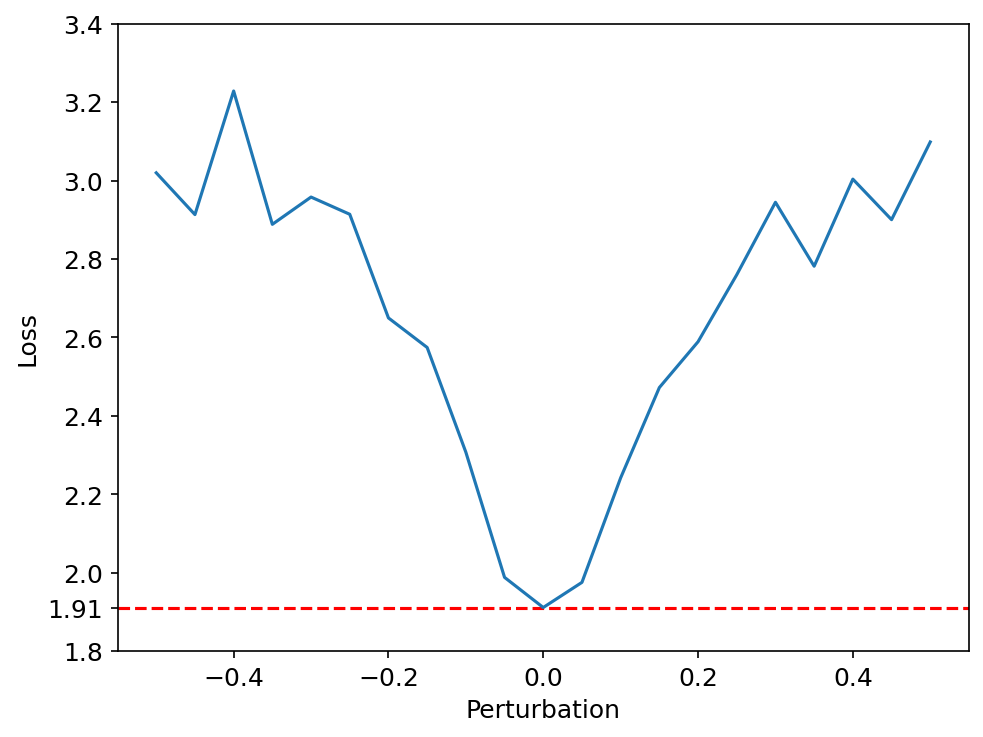

<Figure size 960x720 with 0 Axes>

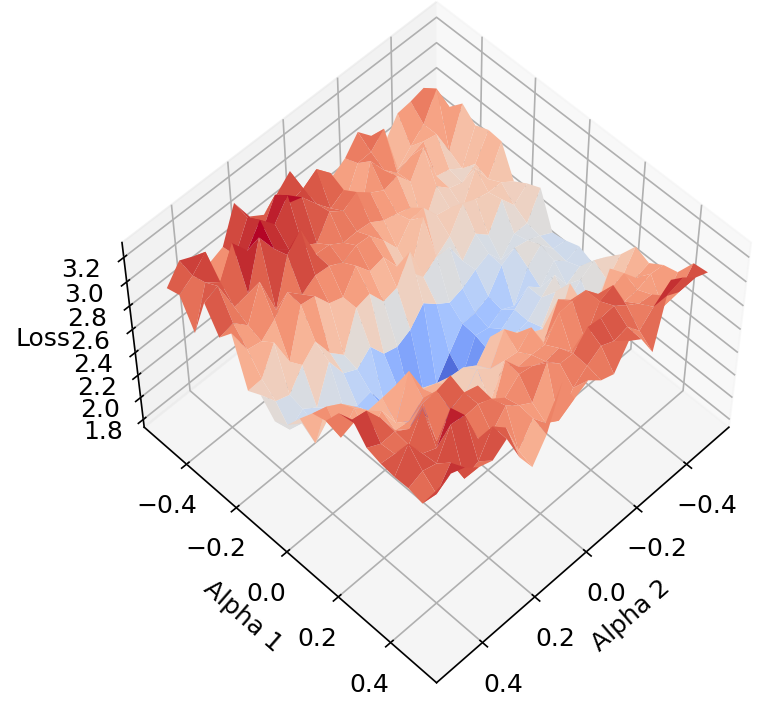

DepthWidthCNN_SGD_mnist
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


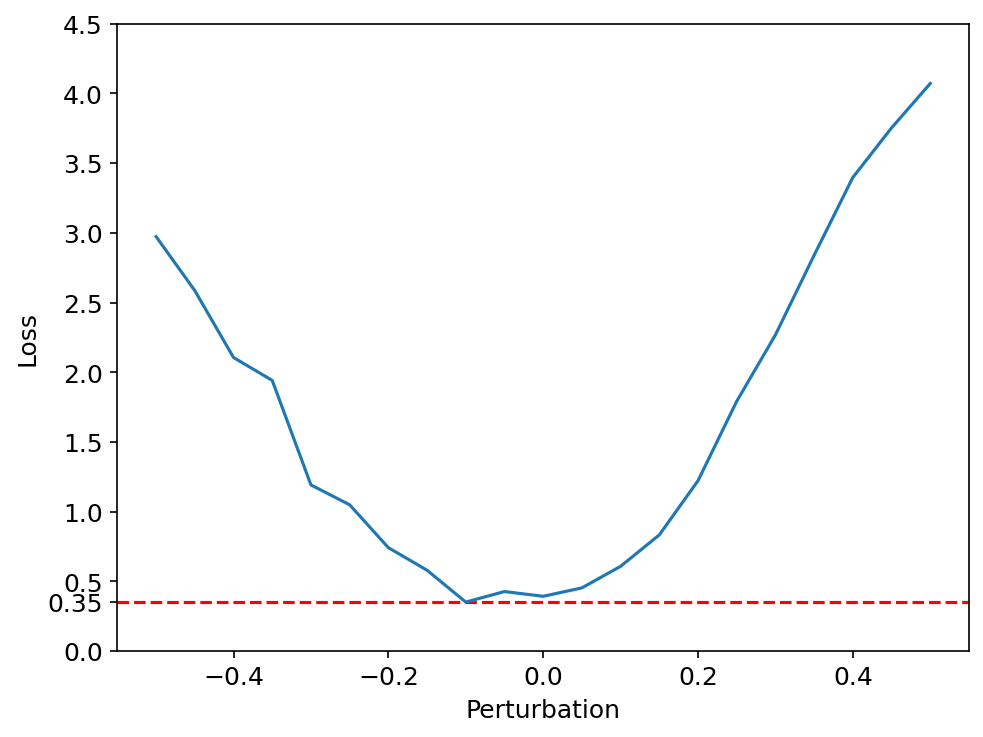

<Figure size 960x720 with 0 Axes>

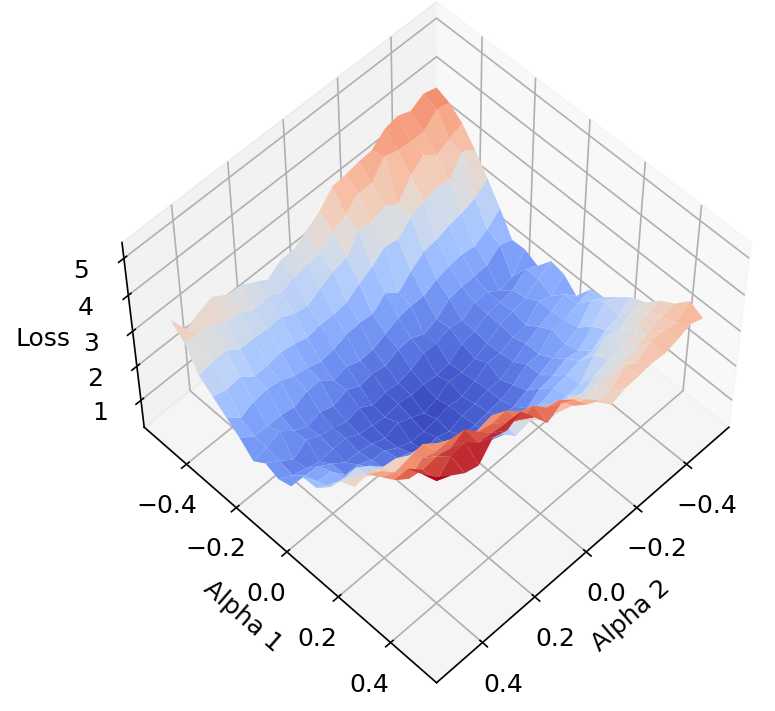

SmallCNN_SGD_fashion
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


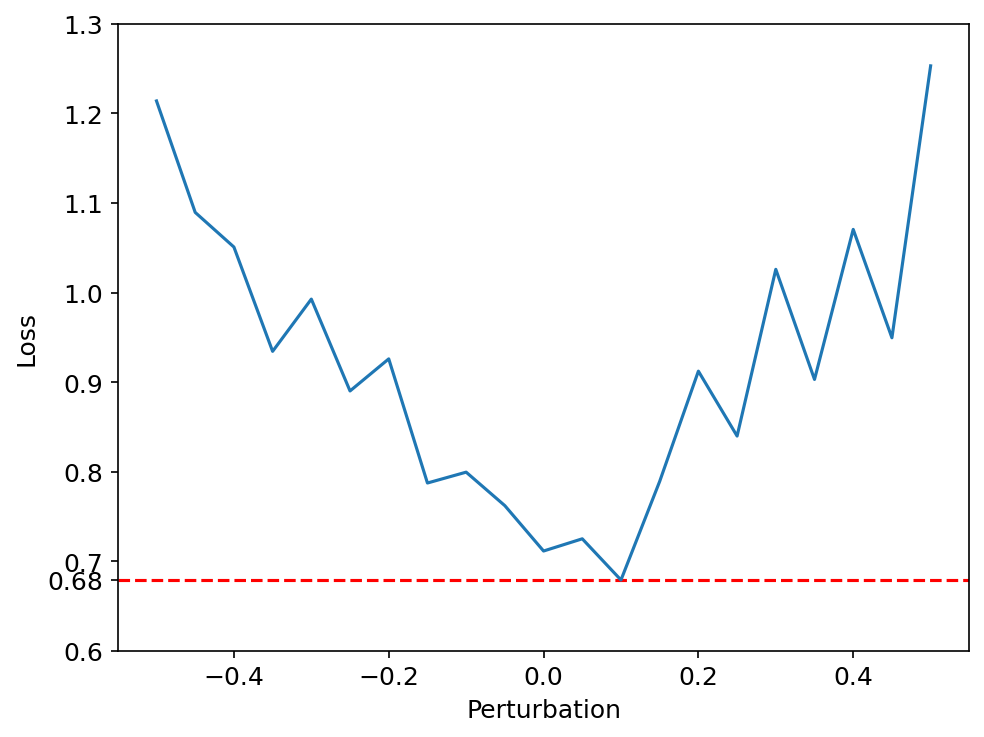

<Figure size 960x720 with 0 Axes>

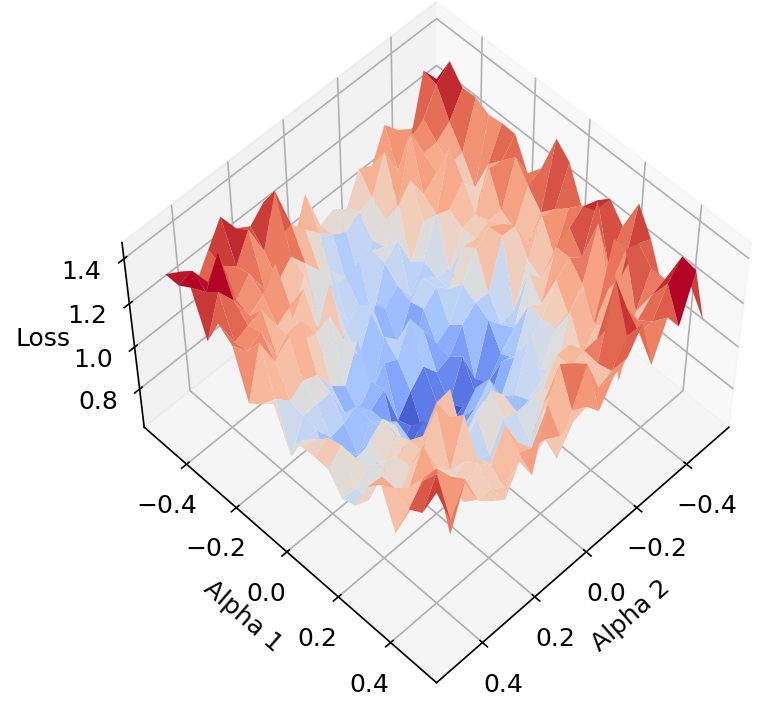

DepthCNN_SGD_cifar10
Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


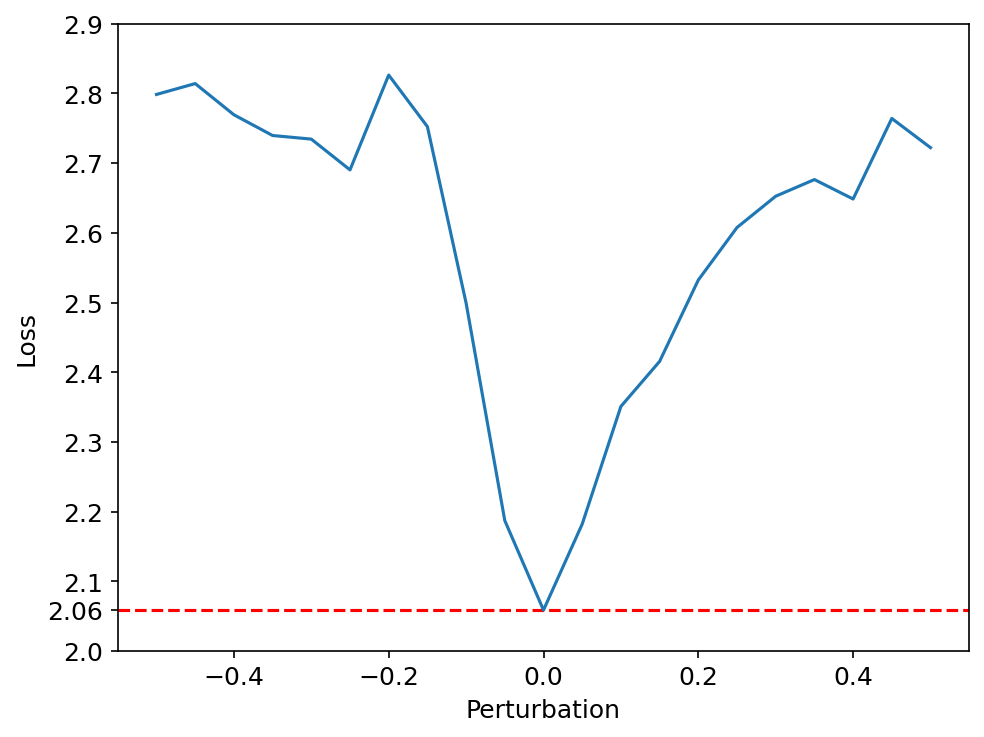

<Figure size 960x720 with 0 Axes>

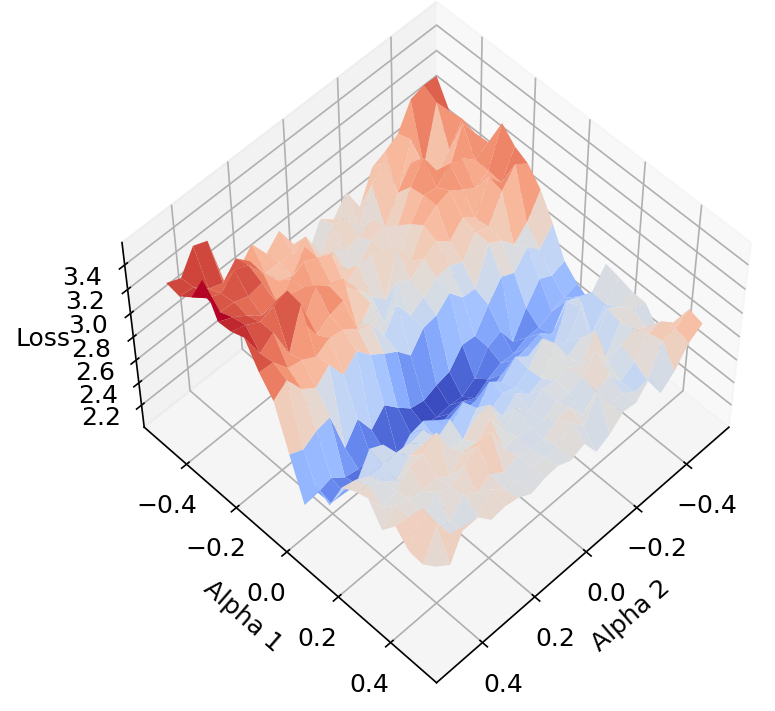

DepthCNN_SGD_fashion
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


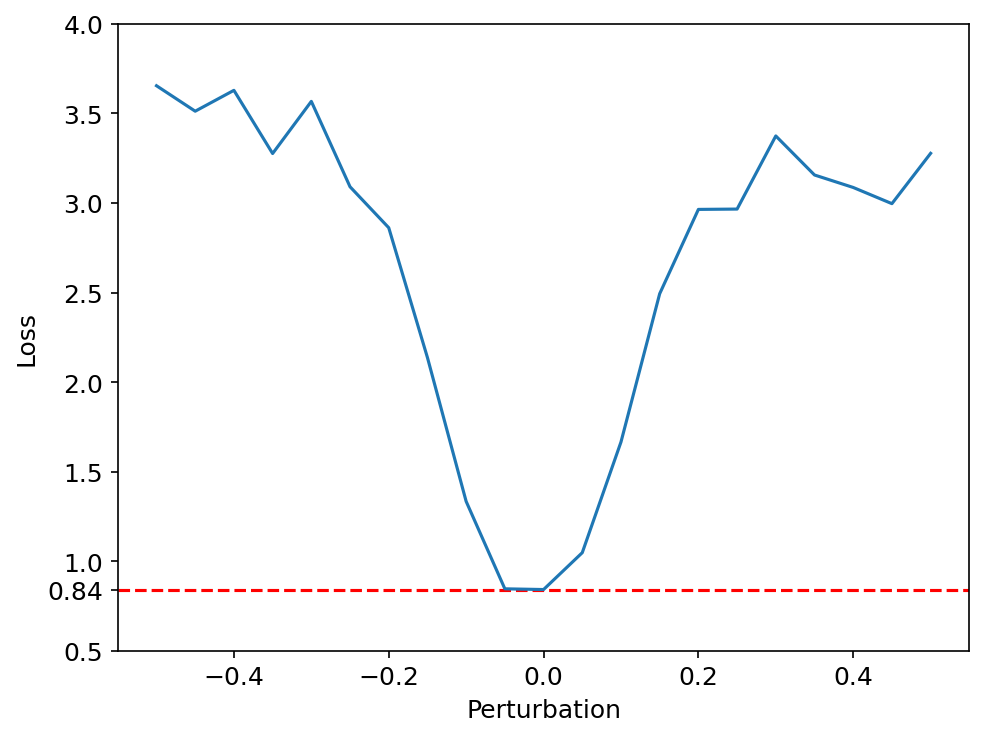

<Figure size 960x720 with 0 Axes>

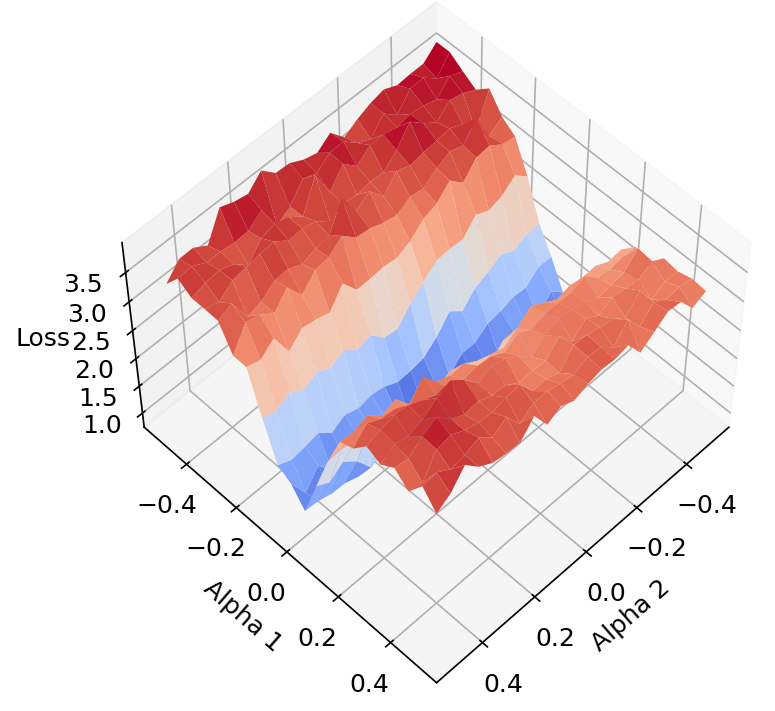

WidthCNN_SGD_cifar10
Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


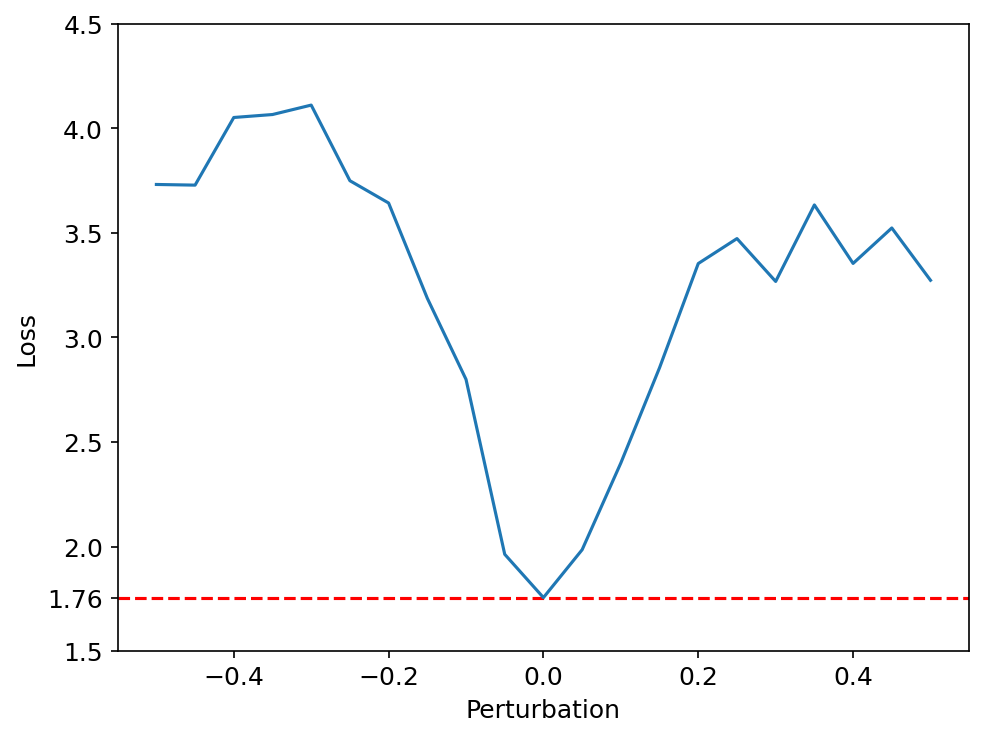

<Figure size 960x720 with 0 Axes>

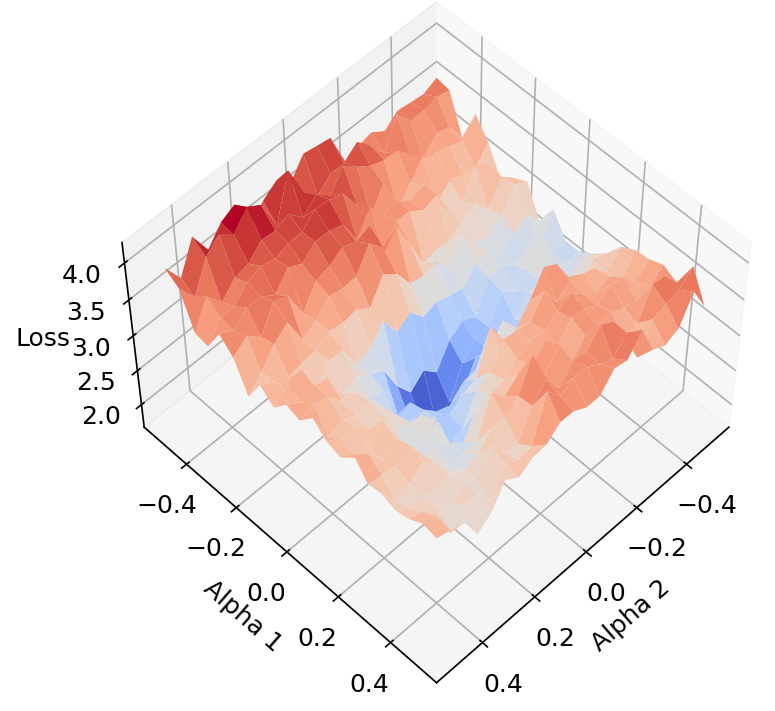

WidthCNN_SGD_fashion
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


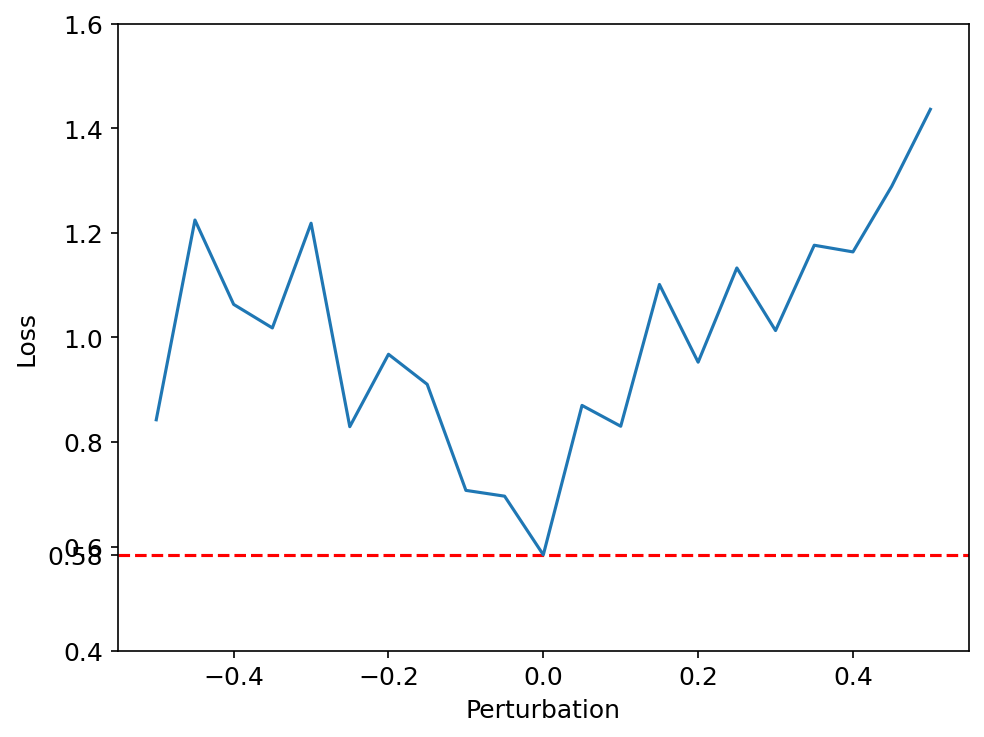

<Figure size 960x720 with 0 Axes>

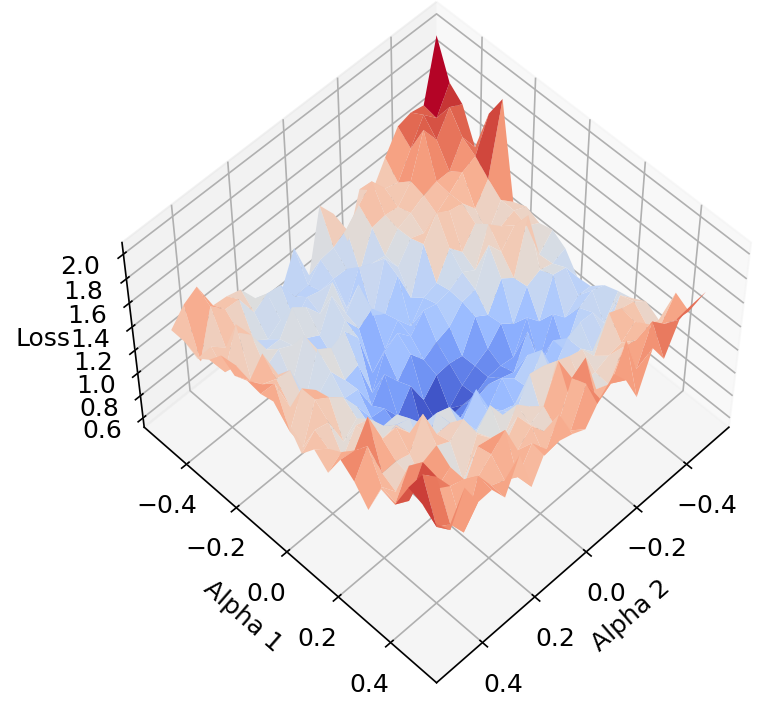

WidthCNN_SGD_mnist
0
1
2
3
4
5
6
7
8


In [ ]:
for (name, dir_path) in runs:
    

    file_names = find_all_pth_files(os.path.join('..', 'checkpoints', 'SGD', 'seed_42', dir_path))
    file_names = sort_file_paths(file_names)
    file_names = file_names[::3]

    print(name)
    f, config = load_checkpoint_config(file_names[0], pref=name)
    _, train_data_loader, test_data_loader, optimizer, accuracy_fn = experiments_maker.make(config, cm.device)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    grad_norms = []
    top_eigenvalues = []
    trace_hessians = []

    pos_eigens = []
    neg_eigens = []

    logged_batches = []

    b_period = len(train_data_loader) // config["checkpoints"]
    epochs = config['epochs']

    for fid, file_name in enumerate(file_names):
        logged_batches.append(int(file_name.split('_')[-1].split('.')[0]))
        model = load_checkpoint_model(file_name, config)
        checkpoint_specs = CheckpointSpecs(name, config, train_data_loader, test_data_loader, optimizer, accuracy_fn, model, full_dataset=False)
        # collect empirical loss and accuracy (train and test) and gradient norm
        train_loss, train_acc, grad_norm = checkpoint_specs.collect_train_loss_acc_gradnorm(compute_grad=True, full_dataset=False)
        test_loss, test_acc = checkpoint_specs.collect_test_loss_acc(full_dataset=False)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        grad_norms.append(grad_norm)
        # collect top eigenvalues of Hessian
        top_eigenvalues.append(checkpoint_specs.top_eigenvalues[0])
        # collect trace of Hessian
        trace_hessians.append(np.mean(checkpoint_specs.trace))

        print(fid)

        # last checkpoints:
        if fid == len(file_names) - 1:
            checkpoint_specs.top_eig_perb_plot()
            checkpoint_specs.top_2_eig_perb_plot()

        density_eigen, density_weight = checkpoint_specs.hessian_esd_plot(save=True, num_bins=10000, sigma_squared=1e-4, overhead=0.01)
        eigs = np.array(density_eigen[0])
        pos_eigens.append(np.sum(np.array(density_eigen[0]) > 0))
        neg_eigens.append(np.sum(np.array(density_eigen[0]) < 0))

    # save as .csv file
    df = pd.DataFrame({'batch': logged_batches, 
                       'train_loss': train_losses, 
                       'train_acc': train_accuracies, 
                       'test_loss': test_losses, 
                       'test_acc': test_accuracies, 
                       'grad_norm': grad_norms, 
                       'top_eigenvalue': top_eigenvalues, 
                       'trace': trace_hessians, 
                       'pos_eigens': pos_eigens, 
                       'neg_eigens': neg_eigens})
    df.to_csv(f'{name}.csv', index=False)

In [73]:
train_losses

[2.3016793727874756,
 2.2978017330169678,
 2.298764944076538,
 2.3060495853424072,
 2.3173880577087402,
 2.2940783500671387,
 2.307723045349121,
 2.3039369583129883,
 2.3085663318634033,
 2.2936623096466064,
 2.3063392639160156,
 2.304361581802368,
 2.308027505874634,
 2.3103036880493164,
 2.316317081451416,
 2.309133768081665,
 2.296633720397949]